# Performance comparison: Compiled vs Non-compiled
In this notebook measure and compare the performance between the model written in pure python against the same model compiled as torchscript

In [1]:
%load_ext memory_profiler
import sys
sys.path.append('../src/')

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from captum.attr import IntegratedGradients

from app.backend.task.scan_process import MRIProcessor
from app.backend.task.model import MRIClassifier

process_iterations = 15
predict_iterations = 200
max_attr_iterations = 10
attr_samples = 3

In [2]:
%%memit
mr_processor = MRIProcessor()
mr_processor("../data/raw/sample_data/OAS30001_MR_d0129_T1w.nii.gz", "../data/raw/sample_data/OAS30001_MR_d0129_brainmask.mgz")

peak memory: 820.25 MiB, increment: 315.66 MiB


### Timing image processing

In [3]:
processing_times = np.zeros(process_iterations)

for i in range(process_iterations):
    start = time.time()
    mr_processor("../data/raw/sample_data/OAS30001_MR_d0129_T1w.nii.gz", "../data/raw/sample_data/OAS30001_MR_d0129_brainmask.mgz")
    processing_times[i] = time.time()-start

print(f"Mean processing time: {processing_times.mean()} (std:{processing_times.std()})")

Mean processing time: 11.639927975336711 (std:0.7300244393753921)


## Native python
In this section we measure the performances using plain python code.
First we measure RAM required for the model and then we proceed in the measurements of prediction time and gradient attribution

In [4]:
%%memit
model = MRIClassifier.load_from_checkpoint("../models/model.ckpt")

peak memory: 601.88 MiB, increment: 92.64 MiB


In [5]:
img = mr_processor("../data/raw/sample_data/OAS30001_MR_d0129_T1w.nii.gz", "../data/raw/sample_data/OAS30001_MR_d0129_brainmask.mgz")
predict_times = np.zeros(predict_iterations)

for i in range(predict_iterations):
    start = time.time()
    model.predict(img)
    predict_times[i] = time.time()-start

print(f"Mean processing time: {predict_times.mean()} (std:{predict_times.std()})")

Mean processing time: 0.363467253446579 (std:0.037921301283389795)


In [6]:
attr_times = np.zeros((attr_samples,max_attr_iterations))

for i in range(max_attr_iterations):
    for j in range(attr_samples):
        start = time.time()
        model.get_attribution(img, n_steps=i+1)
        attr_times[j][i] = time.time()-start

print(f"Mean processing time: {attr_times.mean(axis=0)}")

Mean processing time: [0.6997776  1.76753839 2.54595979 3.32082772 4.37621013 5.17889055
 5.9525578  6.7807467  7.86552159 9.74362763]


### Measure Torchscript
We first convert the model to torchscript, then save and load it. When loaded we also measure memory impact

In [7]:
model_script = model.to_torchscript()
torch.jit.save(model_script, "model.pt")

In [8]:
%%memit
scripted_module = torch.jit.load("model.pt")

peak memory: 1025.30 MiB, increment: 0.36 MiB


In [9]:
img = mr_processor("../data/raw/sample_data/OAS30001_MR_d0129_T1w.nii.gz", "../data/raw/sample_data/OAS30001_MR_d0129_brainmask.mgz")
predict_times_ts = np.zeros(predict_iterations)

x = torch.tensor(np.expand_dims(img, axis=0), dtype=torch.float)
x = torch.unsqueeze(x, 0)

for i in range(predict_iterations):
    start = time.time()
    scripted_module(x)
    predict_times_ts[i] = time.time()-start


print(f"Mean processing time: {predict_times_ts.mean()} (std:{predict_times_ts.std()})")

Mean processing time: 0.3792370629310608 (std:0.03869166420238998)


In [10]:
%%memit
ig = IntegratedGradients(scripted_module)

peak memory: 1027.56 MiB, increment: 0.00 MiB


In [11]:
attr_times_ts = np.zeros((attr_samples,max_attr_iterations))

x = torch.tensor(np.expand_dims(img, axis=0), dtype=torch.float)
x = torch.unsqueeze(x, 0)

for i in range(max_attr_iterations):
    for j in range(attr_samples):
        start = time.time()
        ig.attribute(x, n_steps=i+1)
        attr_times_ts[j][i] = time.time()-start

print(f"Mean processing times: {attr_times_ts.mean(axis=0)}")

Mean processing times: [0.75079226 1.87169131 2.75465878 3.37549361 4.41106192 5.20080741
 6.77141794 6.99448196 8.42501823 9.03578067]


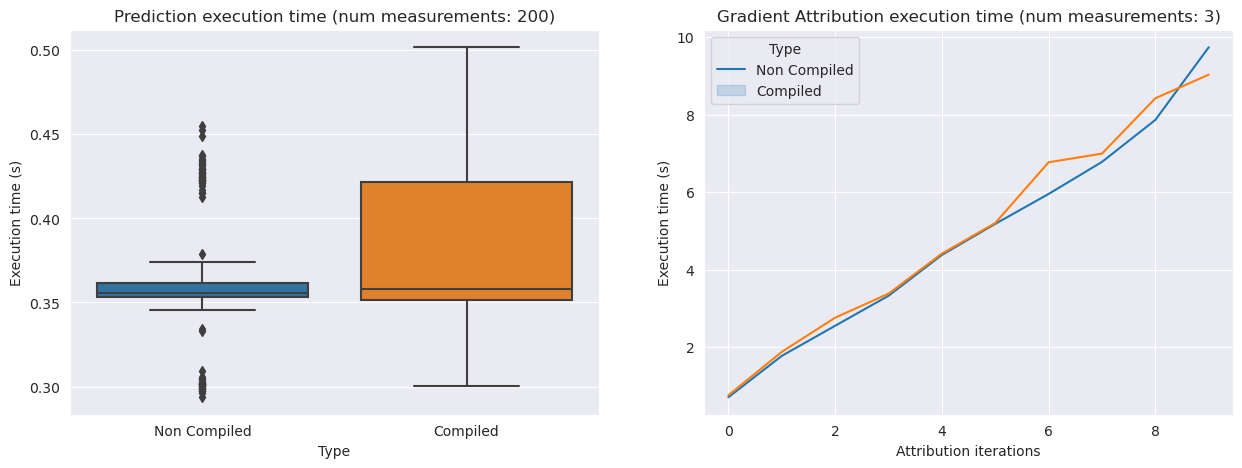

In [12]:
keys = ["Non Compiled", "Compiled"]
predict_values = [predict_times, predict_times_ts]
attr_values = [attr_times.mean(axis=0), attr_times_ts.mean(axis=0)]

img, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=predict_values, ax=ax1)
ax1.set_ylabel("Execution time (s)")
ax1.set_xlabel("Type")
ax1.set_xticklabels(keys)
ax1.set_title(f"Prediction execution time (num measurements: {predict_iterations})")

sns.lineplot(data=attr_values, dashes=False,legend=False, ax=ax2)
ax2.set_xlabel("Attribution iterations")
ax2.set_ylabel("Execution time (s)")
ax2.legend(title='Type', loc='upper left', labels=keys)
ax2.set_title(f"Gradient Attribution execution time (num measurements: {attr_samples})")

os.remove("model.pt")
img.savefig("../reports/performance_comparison.png", bbox_inches='tight', dpi=300, transparent=True)

## Conclusions
From the analysis we cannot observe an improvement in the use of the compiled model neither for the prediction nor for the gradient attribution.
However semms there is room for improvements in the file processing phase.